In [1]:
!pip install torchxrayvision

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement torchxrayvision (from versions: none)
ERROR: No matching distribution found for torchxrayvision


In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchxrayvision as xrv
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

from dataloader import *

In [2]:
model_type = "classification"
assert(model_type in ['classification', 'detection'])

In [3]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224)])


d_covid19 = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",
                                   csvpath="covid-chestxray-dataset/metadata.csv",
                                   transform=transform)

d_nih = xrv.datasets.NIH_Dataset(imgpath="nih-dataset/subset-224",
                                 csvpath="nih-dataset/subset.csv")

#Final dataset
covid_dataset = CovidLandmarksDataset(csv_file='./final-dataset/metadata.csv',
                                           root_dir='./final-dataset/images/',
                                      model_type=model_type,
                                      transform=transform)

{'image': tensor([[[ 0.9843,  0.5843,  0.6000,  ..., -0.5451, -0.6471, -0.6235],
          [ 1.0000,  0.6941,  0.6392,  ..., -0.5294, -0.6549, -0.6941],
          [ 1.0000,  0.7804,  0.6627,  ..., -0.4745, -0.6157, -0.7412],
          ...,
          [ 0.9529, -0.3647, -0.8353,  ..., -0.3020, -0.3020, -0.2941],
          [ 0.9451, -0.3647, -0.8196,  ..., -0.2784, -0.2784, -0.2784],
          [ 0.9608, -0.3412, -0.7882,  ..., -0.2627, -0.2627, -0.2549]]]),
 'gt_label': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       dtype=float32)}

{'ARDS': 0.0,
 'Bacterial Pneumonia': 0.0,
 'COVID-19': 1.0,
 'Chlamydophila': 0.0,
 'Fungal Pneumonia': 0.0,
 'Klebsiella': 0.0,
 'Legionella': 0.0,
 'MERS': 0.0,
 'No Finding': 0.0,
 'Pneumocystis': 0.0,
 'Pneumonia': 1.0,
 'SARS': 0.0,
 'Streptococcus': 0.0,
 'Viral Pneumonia': 1.0}

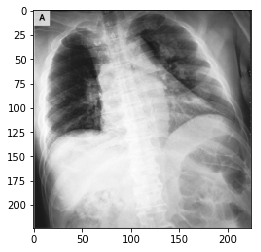

In [4]:
sample = d_covid19[0]
plt.imshow(sample["PA"][0], cmap="Greys_r");
dict(zip(d_covid19.pathologies,sample["lab"]))

In [5]:
d_nih

{'Atelectasis': {0.0: 63, 1.0: 10},
 'Cardiomegaly': {0.0: 72, 1.0: 1},
 'Consolidation': {0.0: 70, 1.0: 3},
 'Edema': {0.0: 73},
 'Effusion': {0.0: 63, 1.0: 10},
 'Emphysema': {0.0: 73},
 'Fibrosis': {0.0: 73},
 'Hernia': {0.0: 72, 1.0: 1},
 'Infiltration': {0.0: 54, 1.0: 19},
 'Mass': {0.0: 66, 1.0: 7},
 'Nodule': {0.0: 70, 1.0: 3},
 'Pleural_Thickening': {0.0: 73},
 'Pneumonia': {0.0: 73},
 'Pneumothorax': {0.0: 71, 1.0: 2}}


NIH_Dataset num_samples=73

In [25]:
covid_dataset[10]['image'].shape

torch.Size([1, 224, 224])

In [7]:
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed = 420

# Creating data indices for training and validation splits:
dataset_size = len(covid_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [8]:
if model_type == 'detection':
    positives = 0
    balanced_val_indices = []
    for idx in val_indices:
        sample = covid_dataset[idx]
        if sample['gt_label'] == 1:
            positives += 1

    samples_left = [positives, positives]
    for idx in val_indices:
        sample = covid_dataset[idx]
        l = int(sample['gt_label'])
        if samples_left[l] > 0:
            samples_left[l] -= 1
            balanced_val_indices.append(idx)

    len(balanced_val_indices)

In [9]:
if model_type == 'detection':
    label_cnt = [0, 0]
    for idx in train_indices:
        sample = covid_dataset[idx]
        l = int(sample['gt_label'])
        label_cnt[l] += 1
    label_cnt

In [10]:
if model_type == 'detection':
    weights = []
    for idx in train_indices:
        sample = covid_dataset[idx]
        l = int(sample['gt_label'])
        weights.append(1 / label_cnt[l])
    len(weights)

In [11]:
# Creating data samplers:

train_dataset = torch.utils.data.Subset(covid_dataset, train_indices)
if model_type == 'detection':
    train_sampler = WeightedRandomSampler(weights, len(weights))
    valid_sampler = SubsetRandomSampler(balanced_val_indices)
elif model_type == 'classification':
    train_sampler = None
    valid_sampler = SubsetRandomSampler(val_indices)

In [12]:
# Creating data loaders:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=2)
validation_loader = torch.utils.data.DataLoader(covid_dataset, batch_size=batch_size,
                                                sampler=valid_sampler, 
                                                num_workers=2)

In [13]:
for i_batch, sample_batched in enumerate(train_loader):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['gt_label'])

0 torch.Size([16, 1, 224, 224]) tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0

17 torch.Size([16, 1, 224, 224]) tensor([[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 

35 torch.Size([16, 1, 224, 224]) tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 

53 torch.Size([16, 1, 224, 224]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 

71 torch.Size([16, 1, 224, 224]) tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 

In [14]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, BCEWithLogitsLoss
from torch.optim import AdamW, SGD

### BASELINE CNN
class XRayNet(nn.Module):
    def __init__(self):
        super(XRayNet, self).__init__()
        
        # input image size 3, 224, 224
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.batch1 = nn.BatchNorm2d(32, affine=True, track_running_stats=True)
        
        # image size 8, 112, 112
        self.conv2 = nn.Conv2d(32, 56, 3, stride = 1, padding = 1)
        self.batch2 = nn.BatchNorm2d(56, affine=True, track_running_stats=True)
        
        # image size 16, 56, 56
        self.conv3 = nn.Conv2d(56, 64, 3, stride = 1, padding = 1)
        self.batch3 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.conv4 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.batch4 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # input size 32, 28, 28
        self.fc1 = nn.Linear(64 * 13 * 13, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 64)
        if model_type == 'detection':
            self.fc4 = nn.Linear(64, 2)
        else:
            self.fc4 = nn.Linear(64, 15)
        
        self.batch5 = nn.BatchNorm1d(512)
        self.batch6 = nn.BatchNorm1d(64)
        
        self.drop = nn.Dropout(p=.3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pool(self.batch1(x))
        
        x = F.relu(self.conv2(x), inplace=True)
        x = self.pool(self.batch2(x))
        x = self.drop(x)
        
        x = F.relu(self.conv3(x), inplace=True)
        x = self.pool(self.batch3(x))
        x = self.drop(x)
        
        x = F.relu(self.conv4(x), inplace=True)
        x = self.pool(self.batch4(x))
        
        x = x.view(-1, 64 * 13 * 13)
        
        x = self.fc1(x)
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.batch5(x)
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.batch6(x)
        x = self.drop(x)
        x = self.softmax(self.fc4(x))
        
        return x

In [15]:
# defining the model
model_name = "transfer"

if model_name == "cnn":
    model = XRayNet()
elif model_name == "transfer":
    model = xrv.models.DenseNet(weights="nih")

In [16]:
# print(model)
# print(len(list(model.parameters())))
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,966,034 trainable parameters


In [17]:
if model_name == "transfer":
    for param in model.parameters():
        param.requires_grad = False
    
    # Parameters of newly constructed modules have requires_grad=True by default
    print(model.features.denseblock4.denselayer16.conv2)
    model.features.denseblock4.denselayer16.conv2 = nn.Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

    print(model.features.norm5)
    model.features.norm5 = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    print(model.classifier)
    if model_type == 'detection':
        model.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)
    else:
        model.classifier = nn.Linear(in_features=1024, out_features=15, bias=True)

Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Linear(in_features=1024, out_features=18, bias=True)


In [18]:
# print(model)
# print(len(list(model.parameters())))
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
    
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,962,959 trainable parameters


In [19]:
print(model)
print(len(list(model.parameters())))
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [20]:
if model_name == "cnn":
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
elif model_name == "transfer":
    # Only parameters of final layers are being optimized
    params = list(model.features.denseblock4.denselayer16.conv2.parameters()) + list(model.features.norm5.parameters()) + list(model.classifier.parameters())
    optimizer = optim.AdamW(params, lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# defining the loss function
if model_type == 'detection':
    class_weight = torch.tensor([0.094,1.0])
    criterion = CrossEntropyLoss(weight = class_weight)
elif model_type == 'classification':
#     class_weight = torch.tensor([0.094,1.0])
    criterion = BCEWithLogitsLoss()
    
use_cuda = False
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    use_cuda = True

In [22]:
def accuracy(output, target):
    output = output >= 0.5
    output = torch.sum(output == target, dim=1) == output.shape[1]
    return torch.sum(output).item()

In [23]:
n_epoch = 300
min_val_loss = np.Inf

train_losses_cnn = []
val_losses_cnn = []
val_accs_cnn = []

for e in range(n_epoch):
    
    running_loss = 0
    val_loss = 0
    correct = 0
    
    # train mode
    for i_batch, sample_batched in enumerate(train_loader):
        
        images = sample_batched['image']
        labels = sample_batched['gt_label']
        
        if model_type == 'detection':
            labels = labels.long()
        
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
#         images = images.unsqueeze(1)
        
        # zero grad
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        running_loss += loss.item() * images.size(0)
        
        loss.backward()
        
        optimizer.step()
    # valid mode
    for i_batch, sample_batched in enumerate(validation_loader):
        
        images = sample_batched['image']
        labels = sample_batched['gt_label']
        
        if model_type == 'detection':
            labels = labels.long()
        
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            
#         images = images.unsqueeze(1)
        model.eval()
        
        output = model(images)
        
        loss = criterion(output, labels)
        
        correct += accuracy(output, labels.long())
        
        val_loss += loss.item() * images.size(0)
        
    model.train()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_val_loss = val_loss / len(validation_loader.dataset)
    acc = (correct/len(valid_sampler))*100
    print('Epoch {}, train loss : {}, validation loss :{}, Accuracy :{}'.format(e, epoch_train_loss, epoch_val_loss, acc))
    
    train_losses_cnn.append(epoch_train_loss)
    val_losses_cnn.append(epoch_val_loss)
    val_accs_cnn.append(acc)
    
    if epoch_val_loss <= min_val_loss:
        print('Validation loss decreased {} -> {}. Saving model...'.format(min_val_loss, epoch_val_loss))
        min_val_loss = epoch_val_loss
#         torch.save(model.state_dict(), 'best.pth')

KeyboardInterrupt: 

In [ ]:
plt.plot(list(range(len(train_losses_cnn))), train_losses_cnn)
# plt.plot(list(range(len(train_losses_cnn))), train_losses)
plt.show()

In [ ]:
plt.plot(list(range(len(val_losses_cnn))), val_losses_cnn)
# plt.plot(list(range(len(val_losses_cnn))), val_losses)
plt.show()

In [ ]:
plt.plot(list(range(len(val_accs_cnn))), val_accs_cnn)
# plt.plot(list(range(len(val_accs_cnn))), val_accs)
plt.show()

In [ ]:
#Loading best model

XRayModel1 = XRayNet()
# XRayModel1.load_state_dict(torch.load('best.pth'))

if use_cuda:
    XRayModel1.cuda()

In [ ]:
#Testing